In [1]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")
from src import utils
from src.dataset2D import MRIDataset2D
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
utils.set_seed(42)

results_dir = '../../results/preprocessed_data/'
labels=["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]


df_train = pd.read_csv(os.path.join(results_dir, 'df_train_imgs.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test_imgs.csv'))
df_train.head(2)


,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view,img_path,npy_path,ratio
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792
1,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792


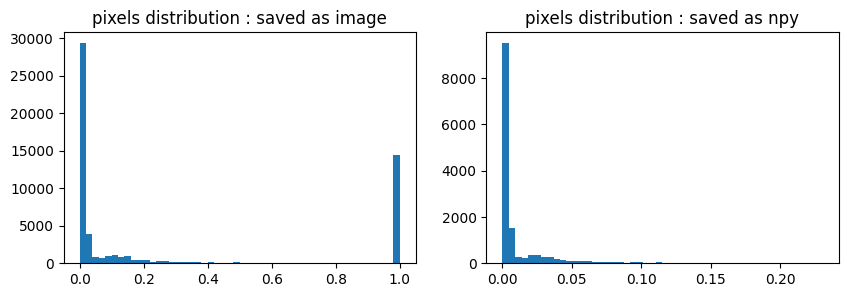

In [2]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("pixels distribution : saved as image")
plt.hist(plt.imread(df_train.loc[0,"img_path"]).flatten(), bins=50)
plt.subplot(1,2,2)
plt.title("pixels distribution : saved as npy")
plt.hist(np.load(df_train.loc[0,"npy_path"]).flatten(), bins=50)
plt.show()

In [4]:
#open_clip_torch==2.23.0

In [14]:
# tsne_embeddings_with_backbones.py
# -*- coding: utf-8 -*-
import os, json, math, random, argparse
from pathlib import Path
from typing import Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from PIL import Image

# extras
import timm
import open_clip
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, pairwise_distances

# ----------------------- Helpers básicos -----------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
CLIP_MEAN     = [0.48145466, 0.4578275, 0.40821073]
CLIP_STD      = [0.26862954, 0.26130258, 0.27577711]

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

def ensure_dir(p: str): Path(p).mkdir(parents=True, exist_ok=True)

def robust_scale01(x: np.ndarray, p_low=1.0, p_high=99.0):
    lo, hi = np.percentile(x, [p_low, p_high])
    if hi <= lo: return np.clip((x - x.min()) / (x.ptp() + 1e-8), 0, 1)
    return np.clip((x - lo) / (hi - lo), 0, 1).astype(np.float32)

def load_slice(img_path: Optional[str], npy_path: Optional[str], prefer: str) -> np.ndarray:
    if prefer == "npy" and npy_path and os.path.exists(npy_path):
        arr = np.load(npy_path)
        if arr.ndim == 3: arr = arr.squeeze()
        return robust_scale01(arr.astype(np.float32))
    if img_path and os.path.exists(img_path):
        im = Image.open(img_path).convert("L")
        arr = np.array(im).astype(np.float32) / 255.0
        return robust_scale01(arr)
    raise FileNotFoundError(f"Missing slice: {img_path} | {npy_path}")

# ----------------------- Backbones -----------------------
class TimmBackbone(nn.Module):
    """Cualquier timm con num_classes=0 -> features directas."""
    def __init__(self, model_name: str, pretrained=True, in_chans=3):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=in_chans)
        self.out_dim = self.model.num_features

    def forward(self, x):  # (B,3,H,W)
        return self.model(x)

def get_visual_outdim(visual: nn.Module, device="cpu", img_size=224):
    # 1) atributos típicos
    for attr in ["output_dim", "embed_dim", "feature_dim", "num_features"]:
        if hasattr(visual, attr):
            val = getattr(visual, attr)
            if isinstance(val, (int, float)):
                return int(val)
    # 2) cabeza/proyección (open_clip timm visual)
    head = getattr(visual, "head", None)
    if head is not None:
        proj = getattr(head, "proj", None)
        if proj is not None and hasattr(proj, "out_features") and proj.out_features is not None:
            return int(proj.out_features)
        if hasattr(head, "out_features") and head.out_features is not None:
            return int(head.out_features)
    # 3) forward con dummy
    with torch.no_grad():
        x = torch.zeros(1, 3, img_size, img_size, device=device)
        y = visual(x)
        # y típicamente (1, D)
        return int(y.shape[-1])


def build_backbone(kind: str, device: str, rad_weights: Optional[str]=None):
    """
    Devuelve: (net, preprocess_fn(Image)->Tensor3xHxW, out_dim, img_size, mean,std)
    """
    # Defaults
    img_size = 224
    mean, std = IMAGENET_MEAN, IMAGENET_STD
    preprocess_from_openclip = None

    if kind == "resnet18_imagenet":
        net = TimmBackbone("resnet18", pretrained=True)
        out_dim = net.out_dim

    elif kind == "dinov2_vitl14":
        net = TimmBackbone("vit_large_patch14_dinov2", pretrained=True)
        out_dim = net.out_dim

    elif kind == "clip_vitb16_openai":
        model, preprocess, _ = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)
        net = model.visual
        out_dim = get_visual_outdim(net, device=device, img_size=224)  # <-- cambia aquí
        preprocess_from_openclip = preprocess
        mean, std = CLIP_MEAN, CLIP_STD

    elif kind == "biomedclip_hf":
        model, preprocess = open_clip.create_model_from_pretrained(
            'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224',
            cache_dir = "/data/cristian/projects/med_data/rise-miccai/pretrained_models/"
        )
        model = model.to(device)
        net = model.visual
        out_dim = get_visual_outdim(net, device=device, img_size=224)  # <-- y aquí
        preprocess_from_openclip = preprocess
        mean, std = CLIP_MEAN, CLIP_STD


    elif kind == "radimagenet_densenet121":
        assert rad_weights is not None and os.path.exists(rad_weights), \
            "Para radimagenet_densenet121 debes pasar --radimagenet_weights a un .pth válido"
        net = TimmBackbone("densenet121", pretrained=False)
        sd = torch.load(rad_weights, map_location="cpu")
        if isinstance(sd, dict) and "state_dict" in sd: sd = sd["state_dict"]
        net.load_state_dict(sd, strict=False)
        out_dim = net.out_dim

    else:
        raise ValueError(f"Backbone no soportado: {kind}")

    net = net.to(device).eval()

    # Preprocess wrappers
    if preprocess_from_openclip is not None:
        def preprocess_fn(img01: np.ndarray) -> torch.Tensor:
            # open_clip preprocess espera PIL RGB
            pil = Image.fromarray((img01*255).astype(np.uint8), mode="L").convert("RGB")
            return preprocess_from_openclip(pil)  # (3,H,W)
    else:
        import torchvision.transforms as T
        tfm = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BICUBIC),
            T.ToTensor(),                          # (1,H,W)
            T.Lambda(lambda x: x.repeat(3,1,1)),
            T.Normalize(mean=mean, std=std),
        ])
        def preprocess_fn(img01: np.ndarray) -> torch.Tensor:
            pil = Image.fromarray((img01*255).astype(np.uint8), mode="L")
            return tfm(pil)

    return net, preprocess_fn, out_dim, img_size, mean, std

# ---------- NEW: agregación por filename ----------
def aggregate_filename(
    sub_df: pd.DataFrame,
    feats: np.ndarray,
    cat: str,
    label_reduce: str = "max"
):
    """
    Agrupa por filename y promedia embeddings. Reduce la etiqueta del cat:
    - 'max'         -> severidad máxima (conservador)
    - 'mean-round'  -> promedio y redondeo al entero más cercano
    - 'majority'    -> voto mayoritario (desempate -> max)
    Retorna:
      agg_df: DataFrame colapsado por filename (1 fila por archivo)
      agg_feats: embeddings promedio por filename
      agg_labels: etiquetas agregadas por filename
    """
    assert label_reduce in {"max", "mean-round", "majority"}
    # Asegurar que tenemos columna filename
    if "filename" not in sub_df.columns:
        sub_df = sub_df.copy()
        sub_df["filename"] = sub_df["path"].apply(os.path.basename)

    # Concatenar para usar groupby sobre índices alineados
    tmp = sub_df[[cat, "patient_id", "filename", "view"]].copy()
    tmp["_row"] = np.arange(len(tmp))

    # índices por filename
    groups = tmp.groupby("filename")["_row"].apply(list)

    agg_rows = []
    agg_feats = []
    agg_labels = []

    for fname, idxs in groups.items():
        idxs = np.asarray(idxs, dtype=int)
        f_mean = feats[idxs].mean(axis=0)            # promedio embeddings
        # reducir etiqueta
        labels = sub_df.loc[idxs, cat].astype(int).to_numpy()
        if label_reduce == "max":
            lab = int(labels.max())
        elif label_reduce == "mean-round":
            lab = int(np.rint(labels.mean()))
        else:  # majority
            vals, cnts = np.unique(labels, return_counts=True)
            lab = int(vals[np.argmax(cnts)])
            # desempate (raro): coge el más severo
            if (cnts == cnts.max()).sum() > 1:
                lab = int(vals.max())

        # fila representativa (tomamos la primera)
        row0 = sub_df.loc[idxs[0]].copy()
        row0["filename"] = fname
        row0[cat] = lab
        row0["n_slices_agg"] = len(idxs)

        agg_rows.append(row0)
        agg_feats.append(f_mean)
        agg_labels.append(lab)

    agg_df = pd.DataFrame(agg_rows).reset_index(drop=True)
    agg_feats = np.vstack(agg_feats).astype(np.float32)
    agg_labels = np.asarray(agg_labels, dtype=int)
    return agg_df, agg_feats, agg_labels


# ----------------------- Métricas & t-SNE -----------------------
def class_separability(features: np.ndarray, labels: np.ndarray):
    overall = features.mean(axis=0, keepdims=True)
    between = 0.0; within = 1e-12
    for c in np.unique(labels):
        Xc = features[labels==c]
        if len(Xc) < 2: continue
        mc = Xc.mean(axis=0, keepdims=True)
        between += len(Xc)*np.sum((mc-overall)**2)
        within  += np.sum((Xc-mc)**2)
    return float(between/within)

def nearest_centroid_confusability(features: np.ndarray, labels: np.ndarray):
    classes = sorted(list(np.unique(labels)))
    cents = {c:features[labels==c].mean(axis=0,keepdims=True) for c in classes}
    dists = {c: pairwise_distances(features, cents[c])[:,0] for c in classes}
    winners = np.argmin(np.stack([dists[c] for c in classes], axis=1), axis=1)
    def rate(a,b):
        return float(np.mean(winners[labels==a] == classes.index(b))) if a in classes and b in classes else np.nan
    return rate(1,2), rate(2,1)

def compute_tsne(X: np.ndarray, seed: int, n_iter=1000, perplexity=None):
    Xs = StandardScaler().fit_transform(X)
    if Xs.shape[1] > 50:
        Xs = PCA(n_components=50, random_state=seed).fit_transform(Xs)
    if perplexity is None:
        N = Xs.shape[0]; perplexity = max(5, min(30, max(5, (N//3)-1)))
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto",
                init="pca", n_iter=n_iter, random_state=seed, metric="euclidean")
    Z = tsne.fit_transform(Xs)
    return Z, perplexity

def detect_outliers(X: np.ndarray, contamination=0.03, seed=1337):
    iso = IsolationForest(n_estimators=300, contamination=contamination, random_state=seed, n_jobs=-1)
    iso.fit(X)
    iso_score = -iso.decision_function(X)
    iso_flag  = (iso.predict(X) == -1).astype(int)
    lof = LocalOutlierFactor(n_neighbors=35, contamination=contamination, n_jobs=-1)
    lof_flag = (lof.fit_predict(X) == -1).astype(int)
    lof_score = -lof.negative_outlier_factor_
    consensus = ((iso_flag + lof_flag) >= 1).astype(int)
    score = (iso_score + lof_score)/2.0
    return {"iso_scores":iso_score,"iso_flags":iso_flag,
            "lof_scores":lof_score,"lof_flags":lof_flag,
            "consensus_flags":consensus,"consensus_scores":score}

# ----------------------- Sampling -----------------------
def balanced_sample_indices(df: pd.DataFrame, category: str, max_per_class=1200,
                            per_patient_max=10, use_patient_level=False, seed=1337):
    rng = random.Random(seed)
    idxs = []
    for cls in [0,1,2]:
        sub = df[df[category]==cls]
        picked = []
        for pid, grp in sub.groupby("patient_id"):
            gidx = grp.index.to_list()
            rng.shuffle(gidx)
            picked.extend(gidx[:per_patient_max])
        if len(picked) > max_per_class:
            picked = rng.sample(picked, max_per_class)
        idxs.extend(picked)
    rng.shuffle(idxs)
    return np.array(idxs, dtype=int)


# ----------------------- Pipeline -----------------------
def run_pipeline(df: pd.DataFrame, args):
    set_seed(args.seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ensure_dir(args.out_dir)

    net, preprocess_fn, feat_dim, img_size, mean, std = build_backbone(
        args.backbone, device=device, rad_weights=args.radimagenet_weights
    )

    # Info de config
    with open(os.path.join(args.out_dir, "config.json"), "w") as f:
        json.dump({
            "backbone": args.backbone,
            "feat_dim": feat_dim,
            "img_size": img_size,
            "prefer_source": args.prefer_source,
            "categories": args.categories,
            "seed": args.seed
        }, f, indent=2)

    for cat in args.categories:
        print(f"\n=== {cat} ===")
        idxs = balanced_sample_indices(
            df, cat, max_per_class=args.max_per_class,
            per_patient_max=args.max_slices_per_patient,
            use_patient_level=False, seed=args.seed
        )
        sub = df.loc[idxs].reset_index(drop=True)

        paths = list(zip(sub.get("img_path",[None]*len(sub)),
                         sub.get("npy_path",[None]*len(sub))))

        feats = []
        with torch.no_grad():
            batch_np = []
            for i,(ip,npyp) in enumerate(paths, start=1):
                arr = load_slice(ip, npyp, args.prefer_source)  # (H,W) [0,1]
                batch_np.append(arr)
                if len(batch_np)==args.batch_size or i==len(paths):
                    xs = torch.stack([preprocess_fn(a) for a in batch_np], dim=0).to(device)
                    f = net(xs).detach().cpu().numpy()
                    feats.append(f)
                    batch_np = []
        feats = np.concatenate(feats, axis=0)  # (N, D)
        labels = sub[cat].astype(int).to_numpy()
        # ... después de calcular feats (N,D) y antes de métricas:
        # feats = np.concatenate(feats, axis=0)
        # labels = sub[cat].astype(int).to_numpy()

        # NEW: agregación por filename
        sub_agg, feats_agg, labels_agg = aggregate_filename(
            sub_df=sub, feats=feats, cat=cat, label_reduce="max"  # cambia a "mean-round" o "majority" si prefieres
        )

        # Reemplazamos sub/feats/labels por los agregados
        sub = sub_agg
        feats = feats_agg
        labels = labels_agg

        # ---- métricas, t-SNE y outliers ya con agregados ----
        fisher = class_separability(feats, labels)
        try:
            silh = silhouette_score(StandardScaler().fit_transform(feats), labels)
        except Exception:
            silh = float("nan")
        conf12, conf21 = nearest_centroid_confusability(feats, labels)
        Z, px = compute_tsne(feats, seed=args.seed, n_iter=args.tsne_iters, perplexity=args.tsne_perplexity)
        out = detect_outliers(feats, contamination=args.contamination, seed=args.seed)

        res = sub.copy()
        res["tsne_x"], res["tsne_y"] = Z[:,0], Z[:,1]
        res["anomaly_flag"]  = out["consensus_flags"]
        res["anomaly_score"] = out["consensus_scores"]
        res["iso_score"]     = out["iso_scores"]
        res["lof_score"]     = out["lof_scores"]
        res["category"]      = cat
        res["fisher_ratio"]  = fisher
        res["silhouette"]    = silh
        res["conf_1_to_2"], res["conf_2_to_1"] = conf12, conf21

        csv_path = os.path.join(args.out_dir, f"tsne_{cat}_{args.backbone}.csv")
        res.to_csv(csv_path, index=False)
        print("CSV:", csv_path)

        topN = min(100, len(res)//10 if len(res)>=10 else len(res))
        res.nlargest(topN, "anomaly_score").to_csv(
            os.path.join(args.out_dir, f"outliers_top{topN}_{cat}_{args.backbone}.csv"), index=False
        )

        # Plot
        plt.figure(figsize=(8,6))
        for c in [0,1,2]:
            m = (labels==c)
            if m.sum()>0:
                plt.scatter(Z[m,0], Z[m,1], s=8, alpha=0.6, label=f"{cat}={c}")
        # centroides
        for c in [0,1,2]:
            m = (labels==c)
            if m.sum()>0:
                cx,cy = Z[m,:].mean(axis=0)
                plt.scatter([cx],[cy], s=120, marker="X", edgecolor="k")
                plt.text(cx,cy, f"C{c}", fontsize=10, ha="center", va="center")
        # outliers
        mo = (res["anomaly_flag"].to_numpy()==1)
        if mo.any():
            plt.scatter(Z[mo,0], Z[mo,1], s=18, facecolors="none", edgecolors="k", linewidths=0.8, label="outlier")

        plt.title(f"{cat} | {args.backbone}\nFisher={fisher:.2f}  Silh={silh:.2f}  perp={px}")
        plt.legend(markerscale=2, fontsize=9)
        plt.tight_layout()
        fig_path = os.path.join(args.out_dir, f"tsne_{cat}_{args.backbone}.png")
        plt.savefig(fig_path, dpi=170)
        plt.close()
        print("PNG:", fig_path)

        # por paciente
        byp = res.groupby("patient_id")["anomaly_flag"].mean().sort_values(ascending=False)
        plt.figure(figsize=(10,3))
        plt.plot(np.arange(len(byp)), byp.values, marker=".")
        plt.title(f"Outlier rate por paciente – {cat} – {args.backbone}")
        plt.xlabel("pacientes ordenados"); plt.ylabel("ratio outliers")
        plt.tight_layout()
        pfig = os.path.join(args.out_dir, f"outlier_rate_by_patient_{cat}_{args.backbone}.png")
        plt.savefig(pfig, dpi=170); plt.close()

# ----------------------- CLI -----------------------
def parse_args():
    ap = argparse.ArgumentParser(description="t-SNE + Outliers para MRI slices con selector de backbone")
    ap.add_argument("--csv", type=str, default=None, help="Ruta a df_train.csv (si no, usa variable df_train del entorno via exec)")
    ap.add_argument("--out_dir", type=str, default="tsne_outputs")
    ap.add_argument("--prefer_source", type=str, default="npy", choices=["npy","img"])
    ap.add_argument("--categories", type=str, nargs="+", default=["Positioning","Contrast","Banding"])
    ap.add_argument("--backbone", type=str, default="biomedclip_hf",
                    choices=["resnet18_imagenet","clip_vitb16_openai","biomedclip_hf","dinov2_vitl14","radimagenet_densenet121"])
    ap.add_argument("--radimagenet_weights", type=str, default=None, help="Ruta a pesos .pth si usas radimagenet_densenet121")
    ap.add_argument("--max_per_class", type=int, default=1200)
    ap.add_argument("--max_slices_per_patient", type=int, default=10)
    ap.add_argument("--batch_size", type=int, default=128)
    ap.add_argument("--tsne_iters", type=int, default=1000)
    ap.add_argument("--tsne_perplexity", type=float, default=None)
    ap.add_argument("--contamination", type=float, default=0.035)
    ap.add_argument("--seed", type=int, default=1337)
    return ap.parse_args()



In [15]:
class Args:
    def __init__(self):
        # Ruta CSV o None si ya tienes df_train en memoria
        self.csv = "df_train.csv"  # o None
        self.out_dir = "tsne_outputs"

        # Preferencia de fuente de imagen
        self.prefer_source = "img"  # "npy" o "img"

        # Categorías a procesar
        self.categories = ["Positioning", "Contrast", "Banding"]

        # Selector de backbone
        self.backbone = "biomedclip_hf"  
        # opciones: "resnet18_imagenet", "clip_vitb16_openai", "biomedclip_hf", "dinov2_vitl14", "radimagenet_densenet121"

        # Ruta a pesos si usas RadImageNet
        self.radimagenet_weights = None  # "/ruta/radimagenet_densenet121.pth"

        # Sampling y batch
        self.max_per_class = 1200
        self.max_slices_per_patient = 10
        self.batch_size = 128

        # t-SNE
        self.tsne_iters = 1000
        self.tsne_perplexity = None  # None = adaptativo

        # Detección de outliers
        self.contamination = 0.035

        # Reproducibilidad
        self.seed = 1337


# Crear instancia
args = Args()

# Si quieres cambiar algo rápido:
args.backbone = "biomedclip_hf"#clip_vitb16_openai"
args.prefer_source = "npy"


# saneo mínimo
needed = ["patient_id","img_path","npy_path","path"]
for c in ["Positioning","Contrast","Banding"]:
    if c not in df_train.columns: print(f"[WARN] columna {c} no está en el CSV (ok si no la usarás)")
run_pipeline(df_train, args)



=== Positioning ===


/tmp/ipykernel_2556616/91623564.py:140: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray((img01*255).astype(np.uint8), mode="L").convert("RGB")


CSV: tsne_outputs/tsne_Positioning_biomedclip_hf.csv
PNG: tsne_outputs/tsne_Positioning_biomedclip_hf.png

=== Contrast ===


/tmp/ipykernel_2556616/91623564.py:140: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray((img01*255).astype(np.uint8), mode="L").convert("RGB")


CSV: tsne_outputs/tsne_Contrast_biomedclip_hf.csv
PNG: tsne_outputs/tsne_Contrast_biomedclip_hf.png

=== Banding ===


/tmp/ipykernel_2556616/91623564.py:140: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray((img01*255).astype(np.uint8), mode="L").convert("RGB")


CSV: tsne_outputs/tsne_Banding_biomedclip_hf.csv
PNG: tsne_outputs/tsne_Banding_biomedclip_hf.png
